# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.


#### Dataset ini bernama **Machine Predictive Maintenance Classification**. Dataset ini berisi data sensor mesin seperti suhu udara, suhu proses, kecepatan rotasi, torsi, status kerusakannya, dan kapan data tersebut diambil. Dataset ini digunakan untuk memprediksi apakah suatu mesin akan rusak atau normal jika diberikan data sensor baru. Dataset ini diperoleh dari kaggle pada link berikut: https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning atau deep learning.

In [1]:
!pip install category_encoders
!pip install xgboost
!pip install scikit-optimize

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
import statsmodels.api as sm
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
import plotly.graph_objs as go
from plotly.offline import iplot
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.svm import SVC
from xgboost import XGBClassifier
import random
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import joblib

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

Jika dataset berupa unstructured data, silakan sesuaikan dengan format seperti kelas Machine Learning Pengembangan atau Machine Learning Terapan

In [2]:
df = pd.read_csv('dataset_raw.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

In [3]:
# Size of Dataset
R = df.shape[0]
C = df.shape[1]
print(f"Number of rows: {R}")
print(f"Number of columns: {C}")

Number of rows: 10000
Number of columns: 10


In [4]:
# dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [5]:
df["Failure Type"].value_counts()

,count
Failure Type,
No Failure,9652
Heat Dissipation Failure,112
Power Failure,95
Overstrain Failure,78
Tool Wear Failure,45
Random Failures,18


In [6]:
print("Distribusi kelas sebelum SMOTE:", Counter(df["Failure Type"]))

Distribusi kelas sebelum SMOTE: Counter({'No Failure': 9652, 'Heat Dissipation Failure': 112, 'Power Failure': 95, 'Overstrain Failure': 78, 'Tool Wear Failure': 45, 'Random Failures': 18})


# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning.

Jika Anda menggunakan data teks, data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah. Khususnya ketika kami menggunakan data tidak terstruktur.

In [7]:
df = df.dropna()

In [8]:
df = df.rename(columns={'Air temperature [K]': 'Air temperature',
                                'Process temperature [K]': 'Process temperature',
                                'Rotational speed [rpm]': 'Rotational speed',
                                'Torque [Nm]': 'Torque',
                                'Tool wear [min]': 'Tool wear',
                                })

df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature', 'Process temperature',
       'Rotational speed', 'Torque', 'Tool wear', 'Target', 'Failure Type'],
      dtype='object')

In [9]:
# Drop unnecessary columns
df = df.drop(['UDI'], axis=1)
df = df.drop(['Product ID'], axis=1)
df = df.drop(['Type'], axis=1)
df = df.drop(['Target'], axis=1)
df = df.reset_index(drop=True)
df.columns

Index(['Air temperature', 'Process temperature', 'Rotational speed', 'Torque',
       'Tool wear', 'Failure Type'],
      dtype='object')

In [10]:
# Drop duplicated rows
print("Number of duplicated rows:", df.shape[0] - df.drop_duplicates().shape[0])
df = df.drop_duplicates()
df = df.reset_index(drop=True)
print()
print("Removing duplicates...")
print()
print("Number of duplicated rows:", df.shape[0] - df.drop_duplicates().shape[0])

Number of duplicated rows: 0

Removing duplicates...

Number of duplicated rows: 0


In [11]:
# Encode ordinal data

categorical_cols = list(set(df.columns.to_list()) - set(df._get_numeric_data().columns.to_list()))

enc_maps = {
    "Failure Type" : [{'col': "Failure Type", 'mapping': {
        "No Failure": 0,
        "Heat Dissipation Failure": 1,
        "Power Failure": 2,
        "Overstrain Failure": 3,
        "Tool Wear Failure": 4,
        "Random Failures": 5,
        }}],
}

for col in categorical_cols:
    enc_map = enc_maps[col]

    enc = OrdinalEncoder(mapping=enc_map)
    df = enc.fit_transform(df)

df.head()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Failure Type
0,298.1,308.6,1551,42.8,0,0
1,298.2,308.7,1408,46.3,3,0
2,298.1,308.5,1498,49.4,5,0
3,298.2,308.6,1433,39.5,7,0
4,298.2,308.7,1408,40.0,9,0


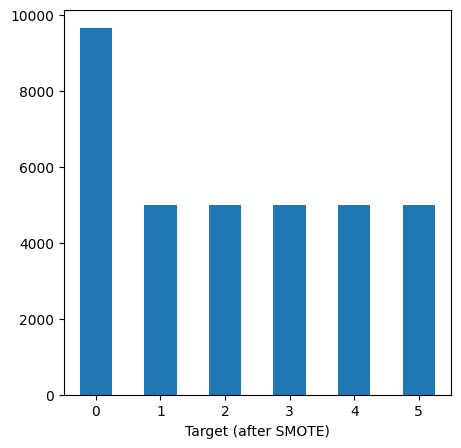

In [12]:
# Oversampling

X = df.drop(['Failure Type'], axis=1)
y = df['Failure Type']

sampling_strategy = {
    0: 9652,
    1: 5000,
    2: 5000,
    3: 5000,
    4: 5000,
    5: 5000,
    }
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X, y = smote.fit_resample(X, y)
X = pd.DataFrame(X, columns=X.columns)
y = pd.Series(y)

ax = y.value_counts().sort_index() \
    .plot(kind='bar',
          figsize=(5, 5))
ax.set_xlabel('Target (after SMOTE)')
plt.xticks(rotation=0)
plt.show()

In [13]:
df = pd.concat([X, y], axis=1)
df.head()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Failure Type
0,298.1,308.6,1551,42.8,0,0
1,298.2,308.7,1408,46.3,3,0
2,298.1,308.5,1498,49.4,5,0
3,298.2,308.6,1433,39.5,7,0
4,298.2,308.7,1408,40.0,9,0


In [14]:
df.to_csv("dataset_preprocessing.csv",index=False)